In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-dataset/item_properties_part1.csv
/kaggle/input/ecommerce-dataset/category_tree.csv
/kaggle/input/ecommerce-dataset/item_properties_part2.csv
/kaggle/input/ecommerce-dataset/events.csv


# Imports

In [73]:
!pip install tensorflow-recommenders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.0 MB/s eta 0:00:00


In [74]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
import tensorflow as tf
import tensorflow_recommenders as tfrs

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [6]:
items_raw_df = pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part1.csv')
items_raw1_df = pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part2.csv')
items_raw_df = pd.concat([items_raw_df, items_raw1_df])
events_raw_df = pd.read_csv('/kaggle/input/ecommerce-dataset/events.csv')

In [7]:
print("shape of items raw dataframe is ",items_raw_df.shape)

shape of items raw dataframe is  (20275902, 4)


In [8]:
print("shape of events raw dataframe is ",events_raw_df.shape)

shape of events raw dataframe is  (2756101, 5)


## EDA for items

In [9]:
items_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [10]:
items_raw_df.head(5)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [11]:
print(
    f"""
    There are {items_raw_df['itemid'].nunique()} distinct items.
    There are {items_raw_df['property'].nunique()} distinct properties.
    """)


    There are 417053 distinct items.
    There are 1104 distinct properties.
    


In [12]:
print("we have ",round((items_raw_df['itemid'].nunique()*100)/items_raw_df.shape[0],2),"percent unique items")

we have  2.06 percent unique items


Having 2cr items makes it difficult to run the system on notebook hence we will only use a subset of it

In [25]:
# Filter the dataframe to include only rows with top 1000 occurring itemids
# Get the top 2000 occurring item IDs
top_2000_items = items_raw_df['itemid'].value_counts().head(2000).index

# Filter items_raw_df to include only these 2000 item IDs
filtered_df = items_raw_df[items_raw_df['itemid'].isin(top_2000_items)]

# Get the first 1000 unique occurrences of itemid
unique_1000 = filtered_df.drop_duplicates(subset='itemid').head(1000)

# Get the remaining rows (including repeated occurrences)
remaining_1000 = filtered_df[~filtered_df.index.isin(unique_1000.index)].head(1000)

# Combine both into the final DataFrame
items_df = pd.concat([unique_1000, remaining_1000])

# Reset index if needed
items_df = items_df.reset_index(drop=True)

In [41]:
unique_1000['itemid']

178       82179
216       40305
335      151099
394      291285
425      291158
          ...  
77321    272803
77595    457405
77691      7223
77843    454924
78123    403159
Name: itemid, Length: 1000, dtype: int64

In [26]:
items_df.shape

(2000, 4)

In [27]:
items_df.nunique()

timestamp      18
itemid       1274
property      142
value        1152
dtype: int64

In [28]:
print(
    f"""
    There are {items_df['itemid'].nunique()} distinct items.
    There are {items_df['property'].nunique()} distinct properties.
    """)


    There are 1274 distinct items.
    There are 142 distinct properties.
    


taking the latest value according to time

In [29]:
items_df = items_df.groupby(['itemid', 'property'])['value'].last().to_frame().reset_index()
items_df.head()

,itemid,property,value
0,142,447,941259 260167
1,305,496,464704 826669 1176545
2,431,283,780351 633705 72789 771257 125839
3,431,794,633705 72789 771257 125839
4,829,981,769062 288796 769062


In [30]:
items_df.shape

(2000, 3)

# EDA for events

In [31]:
events_raw_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [32]:
events_raw_df.shape

(2756101, 5)

In [42]:
events_df = events_raw_df[events_raw_df['itemid'].isin(unique_1000['itemid'].values)]
events_df = events_df.sort_values(['visitorid', 'timestamp']).reset_index(drop=True)

In [44]:
events_df.shape

(22485, 5)

In [45]:
print(
    f"""
    There are {events_df['visitorid'].nunique()} distinct users in events.
    There are {events_df['transactionid'].nunique()} distinct transactions in events.
    There are {events_df['itemid'].nunique()} distinct items in events.
    The actions user can do are {events_df['event'].unique()}.
    """
)


    There are 15286 distinct users in events.
    There are 215 distinct transactions in events.
    There are 650 distinct items in events.
    The actions user can do are ['view' 'addtocart' 'transaction'].
    


In [46]:
print("percentage of unique users are ",round((events_df['visitorid'].nunique()/events_df['visitorid'].shape[0])*100,2))

percentage of unique users are  67.98


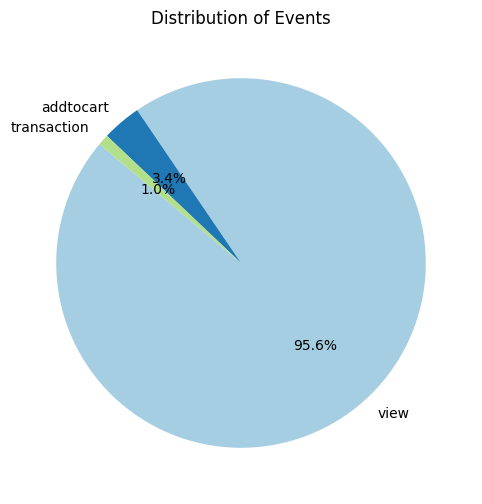

In [47]:
import matplotlib.pyplot as plt

# Count occurrences of each event type
event_counts = events_df['event'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of Events")
plt.show()

## User Activity

In [48]:
events_df['visitorid'].value_counts()

visitorid
816229     196
54791      105
1150086     64
824842      54
77390       53
          ... 
1179         1
1402396      1
1402542      1
1402713      1
1402786      1
Name: count, Length: 15286, dtype: int64

In [49]:
events_df['visitorid'].value_counts().describe()

count    15286.000000
mean         1.470954
std          2.513094
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        196.000000
Name: count, dtype: float64

## Item History

In [50]:
events_df['itemid'].value_counts()

itemid
316753    794
190070    436
100282    403
463617    388
412898    385
         ... 
375810      1
357889      1
359191      1
254282      1
115452      1
Name: count, Length: 650, dtype: int64

In [51]:
events_df['itemid'].value_counts().describe()

count    650.000000
mean      34.592308
std       63.463601
min        1.000000
25%        4.000000
50%       12.000000
75%       37.000000
max      794.000000
Name: count, dtype: float64

Implicit meachnism to rate the items 

In [52]:
events_df['rating'] = events_df['event'].map({'transaction': 5, 'addtocart': 4, 'view': 3})

In [53]:
events_df.drop(['transactionid'],axis=1,inplace=True)

In [54]:
events_df

,timestamp,visitorid,event,itemid,rating
0,1438703679967,94,view,347105,3
1,1433285586381,122,view,301278,3
2,1436748651177,214,view,155319,3
3,1438643613154,399,view,75018,3
4,1440300424364,485,view,449451,3
...,...,...,...,...,...
22480,1431558649765,1407070,view,80754,3
22481,1431558920043,1407070,addtocart,80754,4
22482,1431877680601,1407172,view,315004,3
22483,1438815277214,1407180,view,374841,3


In [55]:
events_df['rating'].value_counts()

rating
3    21498
4      770
5      217
Name: count, dtype: int64

In [56]:
user_item_max_rating = events_df.groupby(['visitorid', 'itemid'])['rating'].max().reset_index()
user_item_max_rating.head()

,visitorid,itemid,rating
0,94,347105,3
1,122,301278,3
2,214,155319,3
3,399,75018,3
4,485,449451,3


# Collaberative Filtering

In [57]:
user_item_max_rating

,visitorid,itemid,rating
0,94,347105,3
1,122,301278,3
2,214,155319,3
3,399,75018,3
4,485,449451,3
...,...,...,...
16969,1406970,358565,3
16970,1407070,80754,4
16971,1407172,315004,3
16972,1407180,374841,3


In [58]:
user_item_max_rating.nunique()

visitorid    15286
itemid         650
rating           3
dtype: int64

## Train Test split

In [59]:
df = user_item_max_rating.copy()

# Sort by visitorid to maintain consistency
df = df.sort_values(by=['visitorid', 'itemid'])

# Ensure each visitorid appears in both train & test sets
train_indices = []
test_indices = []

# Group by visitor and split ratings
for visitor, group in df.groupby('visitorid'):
    if len(group) > 1:  # Only split if user has multiple interactions
        train, test = train_test_split(group, test_size=0.1, random_state=42)  
        train_indices.extend(train.index)
        test_indices.extend(test.index)
    else:
        train_indices.extend(group.index)  # If only 1 interaction, keep in train

# Create Train & Test Sets
train_df = df.loc[train_indices]
test_df = df.loc[test_indices]

# Ensure all test users/items exist in train set
test_df = test_df[
    (test_df['visitorid'].isin(train_df['visitorid'])) &
    (test_df['itemid'].isin(train_df['itemid']))
]

print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")

Train Size: 15977, Test Size: 995


In [67]:
user_item_matrix = train_df.pivot(index='visitorid', columns='itemid', values='rating')

# Fill NaN values with 0 (if treating missing values as no interaction)
user_item_matrix = user_item_matrix.fillna(0)

# Convert to a sparse matrix for efficient computation
user_item_sparse = csr_matrix(user_item_matrix.values)

print("User-Item Matrix Shape:", user_item_matrix.shape)

User-Item Matrix Shape: (15286, 648)


In [68]:
user_item_matrix

itemid,142,305,829,856,1106,2500,2711,2939,3320,5339,...,461311,461764,461765,462437,463617,463852,464116,465556,466302,466350
visitorid,,,,,,,,,,,,,,,,,,,,,
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD based Matrix Factorization

In [70]:
# Define the reader
reader = Reader(rating_scale=(1, 5))

# Load data in Surprise format
train_data = Dataset.load_from_df(train_df[['visitorid', 'itemid', 'rating']], reader).build_full_trainset()
test_data = list(test_df[['visitorid', 'itemid', 'rating']].itertuples(index=False, name=None))

# Train SVD
svd = SVD(n_factors=50, random_state=42)
svd.fit(train_data)

# Predict on test set
predictions = svd.test(test_data)

# Evaluate
print("RMSE:", rmse(predictions))
print("MAE:", mae(predictions))

RMSE: 0.3237
RMSE: 0.3237211892994421
MAE:  0.1489
MAE: 0.1488882659962087


## Weighted Least Squares

In [83]:
# Convert train_df and test_df into TensorFlow datasets
train_ratings = tf.data.Dataset.from_tensor_slices({
    "visitorid": train_df["visitorid"].astype(str).values,
    "itemid": train_df["itemid"].astype(str).values,
    "rating": train_df["rating"].astype(np.float32).values
})

test_ratings = tf.data.Dataset.from_tensor_slices({
    "visitorid": test_df["visitorid"].astype(str).values,
    "itemid": test_df["itemid"].astype(str).values,
    "rating": test_df["rating"].astype(np.float32).values
})

# Build vocab for users and items
unique_users = train_df["visitorid"].astype(str).unique()
unique_items = train_df["itemid"].astype(str).unique()

user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_users),
    tf.keras.layers.Embedding(len(unique_users) + 1, 32)
])

item_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_items),
    tf.keras.layers.Embedding(len(unique_items) + 1, 32)
])

rating_model = tf.keras.Sequential([tf.keras.layers.Dot(axes=1)])

class WALSModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        self.user_model = user_model
        self.item_model = item_model
        self.rating_model = rating_model
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["visitorid"])
        item_embeddings = self.item_model(features["itemid"])
        rating_predictions = self.rating_model([user_embeddings, item_embeddings])
        return self.task(labels=features["rating"], predictions=rating_predictions)

# Compile & Train Model
model = WALSModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
model.fit(train_ratings.batch(512), epochs=5)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3783 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.0644 - total_loss: 9.3783
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3238 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 2.7914 - total_loss: 6.3238
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9390 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.1561 - total_loss: 0.9390
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2362 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 1.2698 - total_loss: 1.2362
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9584 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 0.8980 - total_loss: 0.9584


In [84]:
# Evaluate on test data
print("\nEvaluating WALS Model:")
model.evaluate(test_ratings.batch(512))


Evaluating WALS Model:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4192 - regularization_loss: 0.0000e+00 - root_mean_squared_error: 3.0675 - total_loss: 9.4192  


[9.42818546295166, 3.068263530731201, 0.0, 9.42818546295166]

### Clearly SVD outperform WALS hence we will use user and item vectors by svd

In [88]:
def get_top_n_recommendations(user_id, train_df, svd, n=5):
    """
    Get top N recommended items for a given user using trained SVD model.

    Args:
        user_id (int): The visitor ID for whom recommendations are generated.
        train_df (pd.DataFrame): Training data containing interactions.
        svd (SVD): Trained SVD model.
        n (int): Number of recommendations.

    Returns:
        List[Tuple[int, float]]: Top-N recommended (itemid, predicted_rating) pairs.
    """
    # Get all unique items
    all_items = set(train_df['itemid'].unique())
    
    # Get items already interacted with by the user
    seen_items = set(train_df[train_df['visitorid'] == user_id]['itemid'])
    
    # Get unseen items
    unseen_items = list(all_items - seen_items)

    # Predict ratings for unseen items
    predictions = [(item, svd.predict(user_id, item).est) for item in unseen_items]

    # Sort items by predicted rating in descending order
    top_n_items = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    return top_n_items

In [89]:
# Example: Get top-5 recommendations for user 1146193
user_id = 1146193
top_5_recommendations = get_top_n_recommendations(user_id, train_df, svd, n=5)

print(f"Top 5 Recommendations for User {user_id}: {top_5_recommendations}")

Top 5 Recommendations for User 1146193: [(176419, 3.266513662112493), (90325, 3.2635362488150177), (445074, 3.2231677993800445), (140168, 3.221450095347292), (301278, 3.2069214585302257)]
